In [ ]:
# 匯入 MINST 訓練資料 & 測試資料
import torchvision

train_data = torchvision.datasets.MNIST(root="./datasets", train=True, download=True)
test_data = torchvision.datasets.MNIST(root="./datasets", train=False, download=True)

print("train_data length:", len(train_data))
print("test_data length:", len(test_data))

In [ ]:
# 建立 Cnn Model 訓練模型
import torch
from torch import nn

class Cnn_Model(torch.nn.Module):
    def __init__(self):
        super(Cnn_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3))
        self.max_pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.lin1 = nn.Linear(800, 128)
        self.out = nn.Linear(128, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.max_pool(x)
        x = x.flatten(start_dim=1)
        x = self.lin1(x)
        x = nn.functional.relu(x)
        x = self.out(x)
        x = nn.functional.log_softmax(x, dim=1)
        return x

目前訓練進度:  99
此次訓練預測準確率:  97.60%
此次訓練損失分數:   0.07


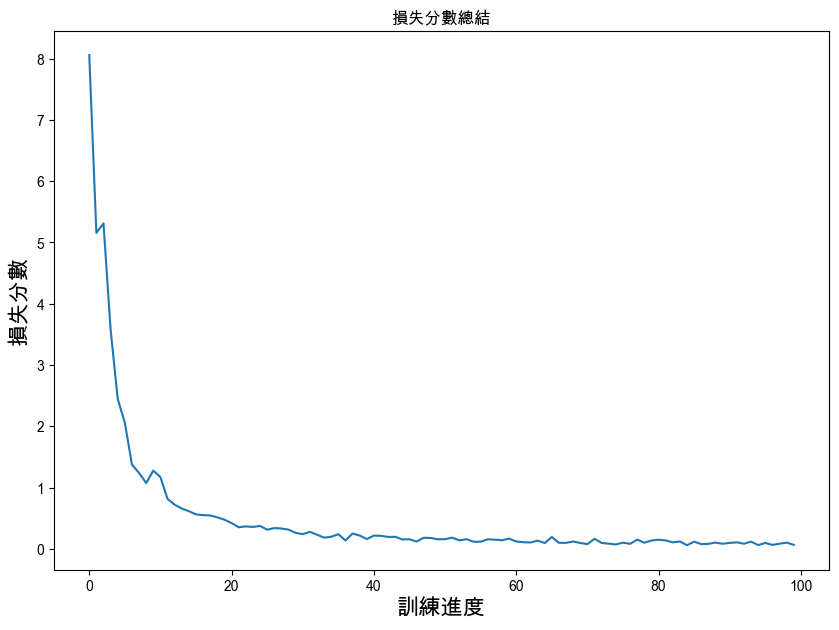

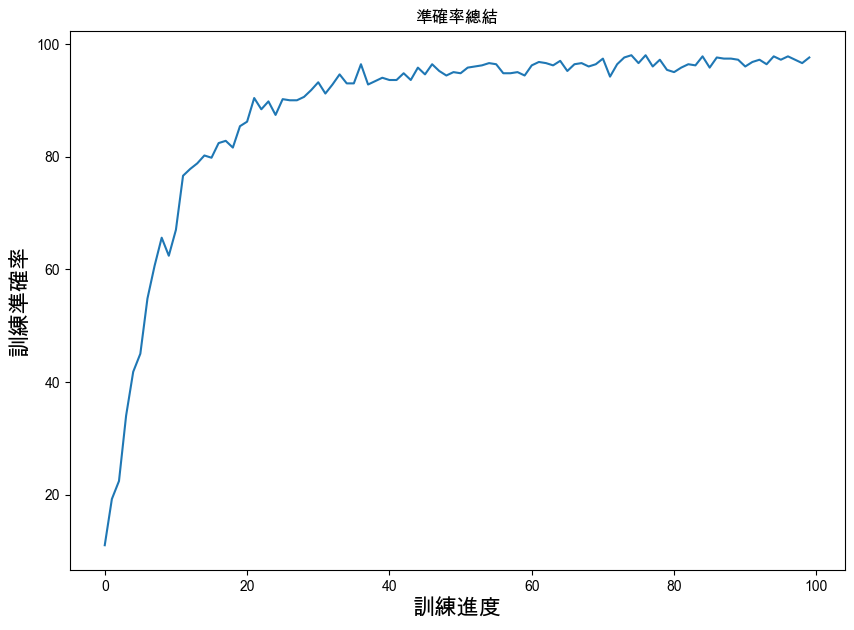

In [67]:
import numpy as np
from IPython.display import clear_output
from torch import tensor
import matplotlib.pyplot as plt
import matplotlib

# 對圖片進行預處理，以符合 PyTorch 的格式需求
def prepare_images(xt):
  out = torch.zeros(xt.shape)
  for i in range(xt.shape[0]):
    img = xt[i].unsqueeze(dim=0) #加入批次軸
    out[i] = img
  return out

model = Cnn_Model()
epochs = 100 #定義訓練迴圈
batch_size = 500 #定義批次大小
lr = 1e-3
opt = torch.optim.Adam(params=model.parameters(),lr=lr)
lossFn = nn.NLLLoss()

losses = []
acc_CNN = []

for i in range(epochs):
  clear_output(wait=True)
  print('目前訓練進度: ', i) #顯示當前訓練進度

  opt.zero_grad()
  batch_ids_CNN = np.random.randint(0, 60000, size=batch_size) #隨機從訓練集中選取樣本，組成訓練批次
  xt = train_data.data[batch_ids_CNN].detach() #產生訓練批次
  xt = prepare_images(xt).unsqueeze(dim=1) #加入通道軸
  yt = train_data.train_labels[batch_ids_CNN].detach() #取得正確的標籤資訊
  pred = model(xt)
  pred_labels = torch.argmax(pred,dim=1) #找出擁有最大機率值的類別，即為模型的預測結果
  acc_ = 100.0 * (pred_labels == yt).sum() / batch_size #計算預測準確率
  print('此次訓練預測準確率: {: .2f}%'.format(acc_.item()))
  acc_CNN.append(acc_)
  loss = lossFn(pred, yt)
  print('此次訓練損失分數:  {: .2f}'.format(loss.item()))
  losses.append(loss)    
  loss.backward()
  opt.step()

acc_CNN = np.array(acc_CNN)
losses = torch.stack(losses).cpu().detach().numpy()

matplotlib.rc('font', family='Arial Unicode Ms')

# 繪製損失分數圖表
plt.figure(figsize=(10,7))
plt.title('損失分數總結')
plt.xlabel("訓練進度", fontsize=16)
plt.ylabel("損失分數", fontsize=16)
plt.plot(losses)

# 繪製準確率圖表
plt.figure(figsize=(10,7))
plt.title('準確率總結')
plt.xlabel("訓練進度", fontsize=16)
plt.ylabel("訓練準確率", fontsize=16)
plt.plot(acc_CNN)

# 儲存模型
torch.save(model.state_dict(), './datasets/mnist_model.ckpt')

In [ ]:
# 驗證測試資料準確率
def test_acc(model):
  acc = 0.
  xt = test_data.data.detach()
  xt = prepare_images(xt).unsqueeze(dim=1)
  yt = test_data.targets.detach()
  preds = model(xt)
  pred_ind = torch.argmax(preds.detach(),dim=1)
  acc = (pred_ind == yt).sum().float() / 10000
  return acc, xt, yt

acc2, xt2, yt2 = test_acc(model)
print('Testing accuracy = ', (acc2*100).item())

In [ ]:
# 抽取驗證
test_id = np.random.randint(0,10000,size=10)

xt = test_data.data[test_id].detach()
xt = prepare_images(xt).unsqueeze(dim=1)
preds = model(xt)
pred_ind = torch.argmax(preds.detach(),dim=1) 
pred_ind = pred_ind.numpy()

for i in range (10):
  x = test_data.data[test_id[i]]
  plt.imshow(x)
  print('\n預測數字為: ', pred_ind[i])  
  plt.pause(0.05)


預測數字為:  0


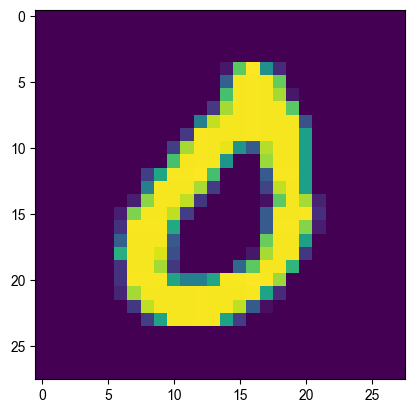


預測數字為:  1


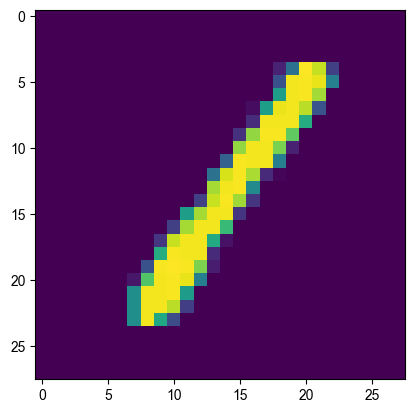


預測數字為:  4


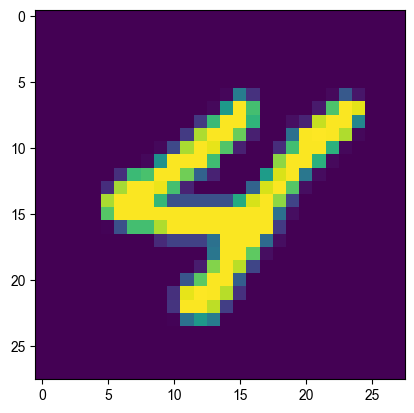


預測數字為:  1


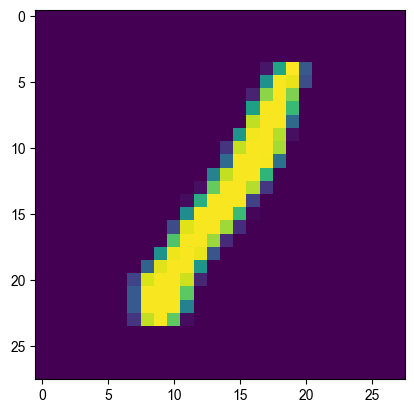


預測數字為:  0


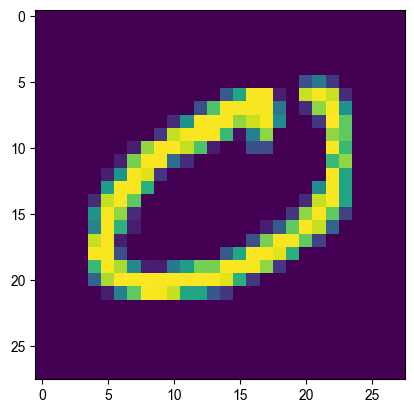


預測數字為:  7


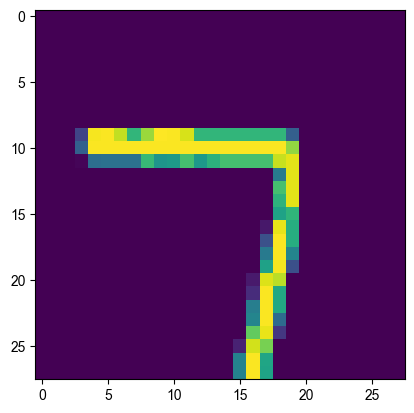


預測數字為:  8


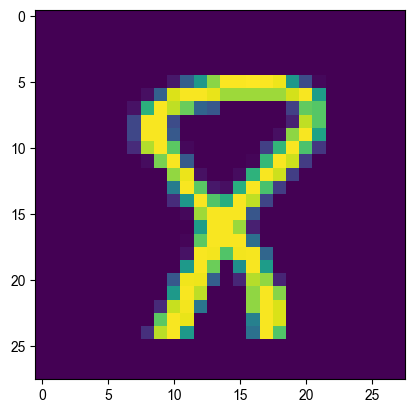


預測數字為:  3


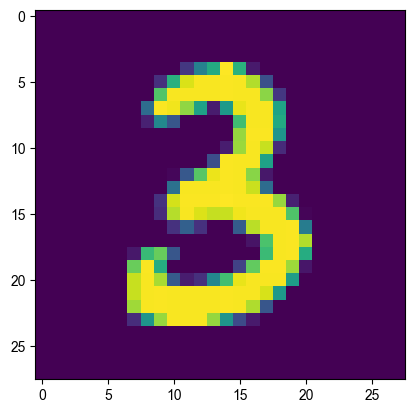


預測數字為:  8


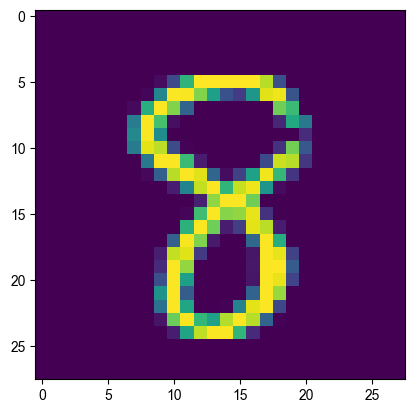


預測數字為:  1


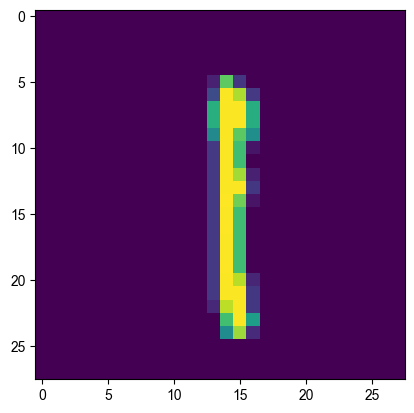

In [69]:
newModel = Cnn_Model()
newModel.load_state_dict(torch.load('./datasets/mnist_model.ckpt'))

est_id = np.random.randint(0,10000,size=10)

xt = test_data.data[test_id].detach()
xt = prepare_images(xt).unsqueeze(dim=1)
preds = newModel(xt)
pred_ind = torch.argmax(preds.detach(),dim=1) 
pred_ind = pred_ind.numpy()

for i in range (10):
  x = test_data.data[test_id[i]]
  plt.imshow(x)
  print('\n預測數字為: ', pred_ind[i])  
  plt.pause(0.05)